This code is to evaluate and test different images for BiomedParse

In [5]:
from google.colab import userdata
import huggingface_hub
huggingface_hub.login(userdata.get('HF_TOKEN'))

In [6]:
from huggingface_hub import hf_hub_download

model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="pretrained")

print(f"Downloaded model file to: {model_file}")

Downloaded model file to: pretrained/biomedparse_v1.pt


In [8]:
!git clone https://github.com/microsoft/BiomedParse

fatal: destination path 'BiomedParse' already exists and is not an empty directory.


In [ ]:
!pip install -r BiomedParse/assets/requirements/requirements.txt

  Cloning https://github.com/MaureenZOU/detectron2-xyz.git to /tmp/pip-req-build-ex6grpa4
  Running command git clone --filter=blob:none --quiet https://github.com/MaureenZOU/detectron2-xyz.git /tmp/pip-req-build-ex6grpa4
  Resolved https://github.com/MaureenZOU/detectron2-xyz.git to commit 42121d75e10d9f858f3a91b6a39f5722c02868f0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Prepari

In [ ]:
import os
try:
    import google.colab
    os._exit(0)
except ImportError:
    pass

In [1]:
import os
os.chdir('/content/BiomedParse')
print(os.getcwd())

/content/BiomedParse


In [2]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "../pretrained/biomedparse_v1.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

Deformable Transformer Encoder is not available.


/usr/local/lib/python3.11/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In this section we analyze a CT image

In [3]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats

In [4]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

In [5]:
def plot_segmentation_masks(original_image, segmentation_masks, texts, rotate=0):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(np.rot90(original_image, rotate), cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):

        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(np.rot90(mask_temp, rotate), alpha=0.9)
        ax[i+1].imshow(np.rot90(original_image, rotate), cmap='gray', alpha=0.5)


    plt.show()

In [6]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_nifti


def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):
    image = read_nifti(file_path, is_CT, slice_idx, site=site,
                       HW_index=HW_index, channel_idx=channel_idx)

    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)

    return image, pred_mask


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.3 MB/s eta 0:00:00


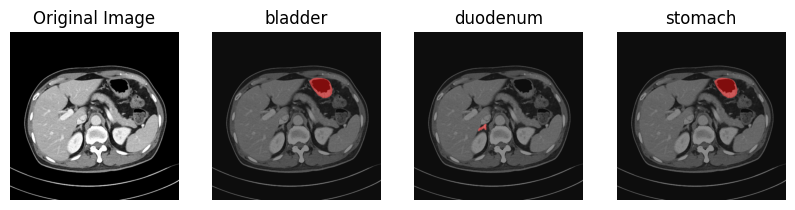

bladder P-value: 0.00011799286278552978
duodenum P-value: 0.4607898107914585
stomach P-value: 0.29584250316671645


In [7]:
image_path = 'examples/amos_0328.nii.gz'
#text_prompt = ['kidney', 'liver', 'pancreas']
text_prompt = ['bladder', 'duodenum', 'stomach']
slide_idx = 68

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=True, slice_idx=slide_idx, site='abdomen', rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'CT-Abdomen', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


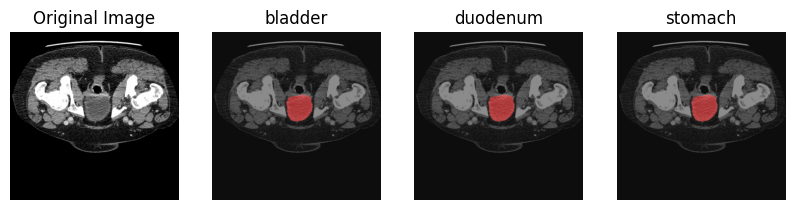

bladder P-value: 0.5703922048876393
duodenum P-value: 0.3628923568223222
stomach P-value: 0.7256746831900922


In [ ]:

image_path = '/content/drive/MyDrive/BioParse/volume-114.nii.gz'
#text_prompt = ['kidney', 'liver', 'pancreas']
text_prompt = ['bladder', 'duodenum', 'stomach']
slide_idx = 68

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=True, slice_idx=slide_idx, site='abdomen', rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'CT-Abdomen', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

ESTE ES EL EJERCICIO PARA PATOLOGIA

In [ ]:
# RGB image input of shape (H, W, 3). Currently only batch size 1 is supported.
image = Image.open('examples/Part_1_516_pathology_breast.png', formats=['png'])
image = image.convert('RGB')

# text prompts querying objects in the image. Multiple ones can be provided.
#prompts = ['neoplastic cells', 'inflammatory cells']
prompts = ['fibroblasts', 'lymphocytes cells']
pred_mask = interactive_infer_image(model, image, prompts)
pred_mask.shape

(2, 1024, 1024)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image = Image.open('/content/drive/MyDrive/BioParse/HE_breast_3.png', formats=['png'])


In [ ]:
#prompts = ['fibroblasts', 'lymphocytes cells']
prompts = ['neoplastic cells', 'inflammatory cells']
#prompts = ['malignant breast cancer cells', 'benign breast cancer cells']
pred_mask = interactive_infer_image(model, image, prompts)
pred_mask.shape

(2, 1024, 1024)

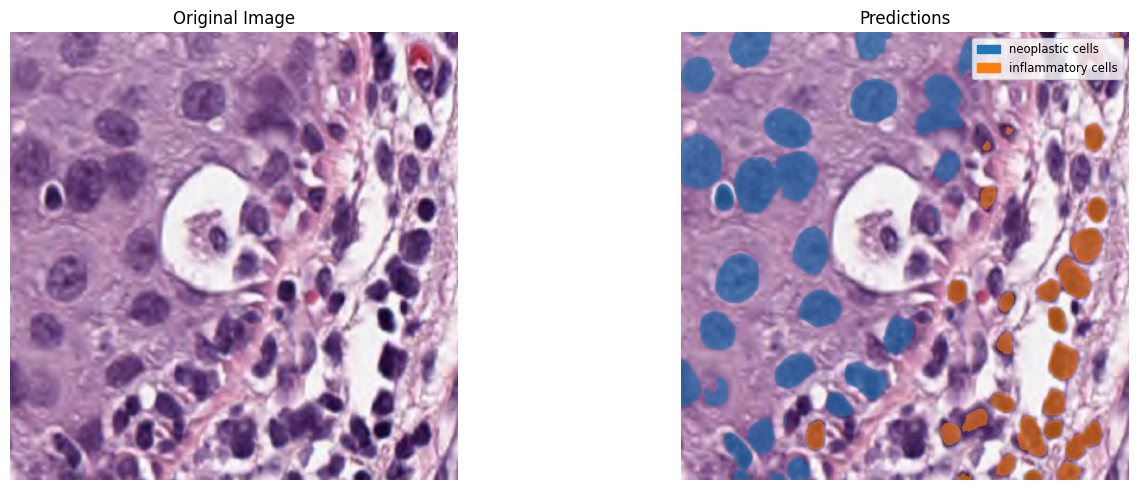

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as mpatches

def overlay_masks(image, masks, colors):
    overlay = image.copy()
    overlay = np.array(overlay, dtype=np.uint8)
    for mask, color in zip(masks, colors):
        overlay[mask > 0] = (overlay[mask > 0] * 0.4 + np.array(color) * 0.6).astype(np.uint8)
    return Image.fromarray(overlay)

def generate_colors(n):
    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * val) for val in cmap(i)[:3]) for i in range(n)]
    return colors

#original_image = Image.open('examples/Part_1_516_pathology_breast.png').convert('RGB')
original_image = Image.open('/content/drive/MyDrive/BioParse/HE_breast_3.png').convert('RGB')
colors = generate_colors(len(prompts))

pred_overlay = overlay_masks(original_image, [1*(pred_mask[i] > 0.5) for i in range(len(prompts))], colors)

#gt_overlay = overlay_masks(original_image, gt_masks, colors)

legend_patches = [mpatches.Patch(color=np.array(color) / 255, label=prompt) for color, prompt in zip(colors, prompts)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches, loc='upper right', fontsize='small')

#axes[2].imshow(gt_overlay)
#axes[2].set_title("Ground Truth")
#axes[2].axis('off')
#axes[2].legend(handles=legend_patches, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()